In [46]:
# import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation,Conv2D,Dense,MaxPool2D,Dropout,Flatten,Input,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import Xception
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
%matplotlib inline
from plot_keras_history import plot_history

In [19]:
#pip install plot_keras_history

In [3]:
# paths for training data and test data
train_dir = '../input/firedata/Training/Training'
test_dir = '../input/firedata/Test/Test'

In [4]:
# Augmenting the training data and splitting 20% data for validation using ImageDataGenerartor
train_images = ImageDataGenerator(   rescale=1.0/255,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.2 )

# training data (80%)
training_data = train_images.flow_from_directory(   train_dir,
                                                    target_size=(254,254), 
                                                    color_mode='rgb', 
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    seed=120,
                                                    batch_size=64,
                                                    subset='training')
# validation data (20%)
validation_data = train_images.flow_from_directory(     train_dir, 
                                                        target_size=(254,254),
                                                        color_mode='rgb',
                                                        class_mode='binary',
                                                        batch_size=64,
                                                        shuffle=True,
                                                        seed=120,
                                                        subset='validation')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


In [5]:
# Loading the test data
test_images = ImageDataGenerator(rescale=1.0/255)

test_data = test_images.flow_from_directory(test_dir,
                                            target_size=(254,254), 
                                            color_mode='rgb', 
                                            class_mode='binary',
                                            shuffle=False,
                                            batch_size=1)

Found 8617 images belonging to 2 classes.


# **Transfer Learning Using Xception Model**

In [ ]:
# Using Xception model for transfer learning
# workflow
# 1. create model
# 2. compile the model
# 3. Fit the model on training data
# 4. Evaluate the finetuned model on test data

In [8]:
# Instantiating a base model with pre-trained weights
base_model = Xception(weights='imagenet',
                      input_shape=(254,254,3), # since include_top = false
                      include_top=False)

# Freezing the base model
base_model.trainable = False

# Create a new model on top
inputs = Input(shape=(254,254,3))

x = base_model(inputs,training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  
outputs = Dense(1)(x)

model = Model(inputs,outputs)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [13]:
# for i,layer in enumerate(base_model.layers):
#     print(i,layer.name,layer.trainable)

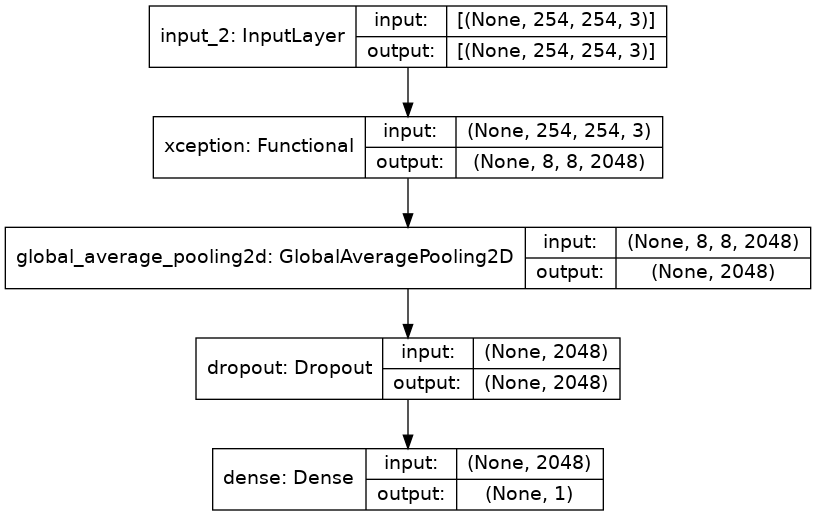

In [18]:
plot_model(model, to_file='model.png',show_shapes=True,dpi=96)

In [14]:
# compile the model created
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# Defining the early stopping criteria
early_stop = EarlyStopping( monitor="val_loss",
                            min_delta=1e-5,
                            patience=10,
                            verbose=1,
                            mode="min",
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=10,
                              verbose=1,
                              mode="min",# In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing
                              min_delta=0.0001)

check_point = ModelCheckpoint(  filepath=" weights.{epoch:02d}-{val_loss:.2f}.h5",
                                monitor="val_loss",
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode="min")

tb_logs = TensorBoard(log_dir="logs")

In [21]:
# train the model on new training data
my_callbacks = [early_stop, reduce_lr, check_point, tb_logs]
batch_size = 64
epochs = 20

history = model.fit(
                    training_data,
                    steps_per_epoch=training_data.samples // batch_size,
                    validation_data = validation_data, 
                    validation_steps = validation_data.samples // batch_size,
                    callbacks=my_callbacks,
                    epochs=epochs,
                    verbose=1
    )
model.save('./Xception_pretrained.h5')

Epoch 1/20
492/492 [==============================] - 888s 2s/step - loss: 4.0444 - accuracy: 0.7207 - val_loss: 0.2161 - val_accuracy: 0.9685

Epoch 00001: val_loss improved from inf to 0.21610, saving model to  weights.01-0.22.h5
Epoch 2/20
492/492 [==============================] - 649s 1s/step - loss: 0.4853 - accuracy: 0.9437 - val_loss: 0.2785 - val_accuracy: 0.9585

Epoch 00002: val_loss did not improve from 0.21610
Epoch 3/20
492/492 [==============================] - 644s 1s/step - loss: 0.5996 - accuracy: 0.9207 - val_loss: 0.1456 - val_accuracy: 0.9699

Epoch 00003: val_loss improved from 0.21610 to 0.14560, saving model to  weights.03-0.15.h5
Epoch 4/20
492/492 [==============================] - 651s 1s/step - loss: 0.3947 - accuracy: 0.9496 - val_loss: 0.1851 - val_accuracy: 0.9699

Epoch 00004: val_loss did not improve from 0.14560
Epoch 5/20
492/492 [==============================] - 651s 1s/step - loss: 0.3780 - accuracy: 0.9475 - val_loss: 0.1812 - val_accuracy: 0.9571

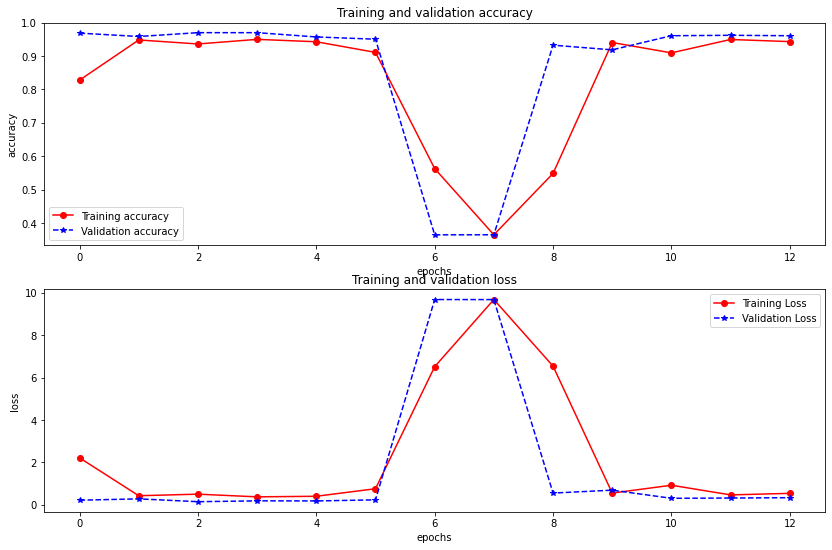

In [22]:
# Plotting loss and accruracy on training data and validation data before finetuning
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14,9))
plt.subplot(211)
plt.plot(epochs, acc, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--*', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(212)
plt.plot(epochs, loss, 'r-o', label='Training Loss')
plt.plot(epochs, val_loss, 'b--*', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig('base_model_result.png')

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <AxesSubplot:title={'center':'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

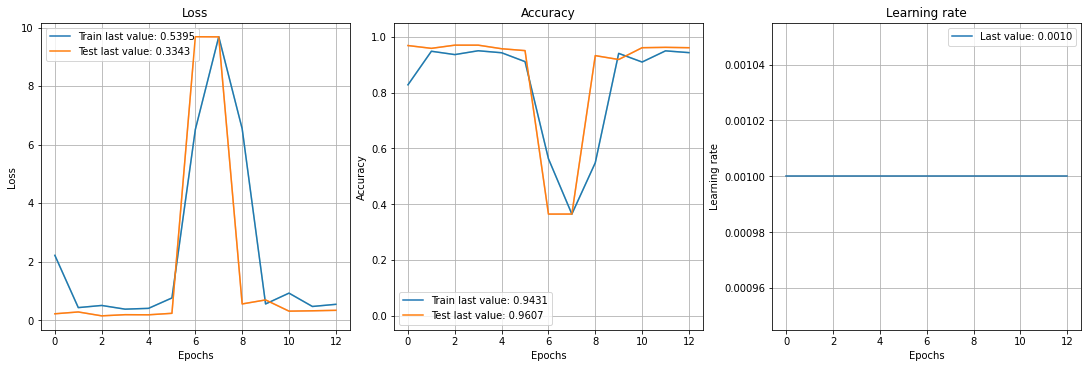

In [23]:
plot_history(history, path="base_model_results_2.png")

# **Fine tuning**

In [25]:
# Once the model has converged on the new data, we can unfreeze all or part of the base model
# and retrain the whole model end-to-end with a very low learning rate.

# Unfreezing the whole base model
base_model.trainable = True


# It's important to recompile the model after making any changes to the `trainable` attribute 
# of any inner layer, so that the changes are take into account

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss='binary_crossentropy',
              metrics=['acc'])


# Training end-to-end. 
history = model.fit(training_data,
                    steps_per_epoch=training_data.samples  // batch_size,
                    epochs=20,
                    validation_data = validation_data, 
                    validation_steps = validation_data.samples // batch_size,
                    callbacks=my_callbacks,
                    verbose=1
    )
model.save('./Xception_finetuned.h5')

Epoch 1/20
492/492 [==============================] - 848s 2s/step - loss: 0.2932 - acc: 0.9657 - val_loss: 0.1348 - val_acc: 0.9748

Epoch 00001: val_loss improved from 0.14560 to 0.13482, saving model to  weights.01-0.13.h5
Epoch 2/20
492/492 [==============================] - 844s 2s/step - loss: 0.0680 - acc: 0.9875 - val_loss: 0.1060 - val_acc: 0.9822

Epoch 00002: val_loss improved from 0.13482 to 0.10602, saving model to  weights.02-0.11.h5
Epoch 3/20
492/492 [==============================] - 847s 2s/step - loss: 0.0817 - acc: 0.9831 - val_loss: 0.1205 - val_acc: 0.9795

Epoch 00003: val_loss did not improve from 0.10602
Epoch 4/20
492/492 [==============================] - 842s 2s/step - loss: 0.0325 - acc: 0.9903 - val_loss: 0.1625 - val_acc: 0.9759

Epoch 00004: val_loss did not improve from 0.10602
Epoch 5/20
492/492 [==============================] - 841s 2s/step - loss: 0.0340 - acc: 0.9930 - val_loss: 0.1455 - val_acc: 0.9802

Epoch 00005: val_loss did not improve from 0

In [26]:
# evaluating the fine tuned model
test = model.evaluate(test_data)
test_loss , test_acc = test[0],test[1]

valid = model.evaluate(validation_data)
valid_loss,valid_acc =  valid[0],valid[1]

train = model.evaluate(training_data)
train_loss,train_acc = train[0],train[1]

# creating dataframe with loss and accuracy on train, validation and test sets
pd.DataFrame({'test':{'loss':test_loss,'accuracy':test_acc},
              'validation':{'loss':valid_loss,'accuracy':valid_acc},
              'train':{'loss':train_loss,'accuracy':train_acc}})

493/493 [==============================] - 540s 1s/step - loss: 0.0153 - acc: 0.9961


,test,validation,train
loss,1.770755,0.112705,0.015336
accuracy,0.826158,0.983109,0.996127


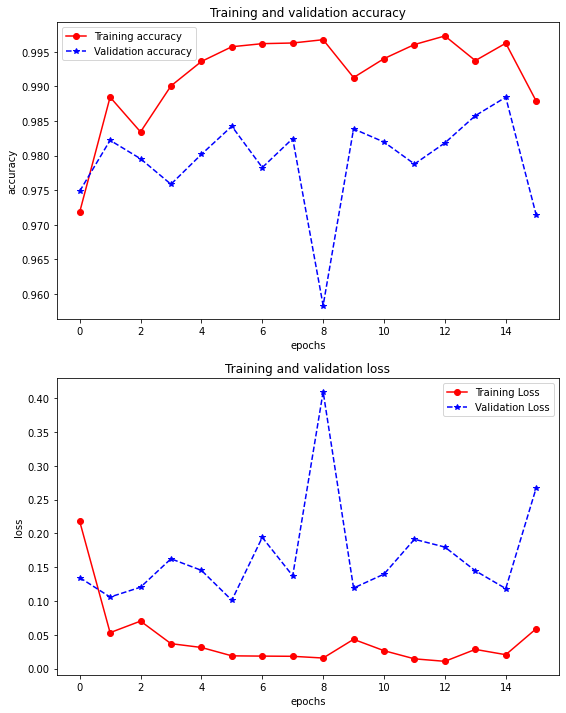

In [30]:
# Plotting loss and accruracy on training data and validation data after finetuning
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(9,12))
plt.subplot(211)
plt.plot(epochs, acc, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--*', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(212)
plt.plot(epochs, loss, 'r-o', label='Training Loss')
plt.plot(epochs, val_loss, 'b--*', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig('finetuned_model_result.png')

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <AxesSubplot:title={'center':'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

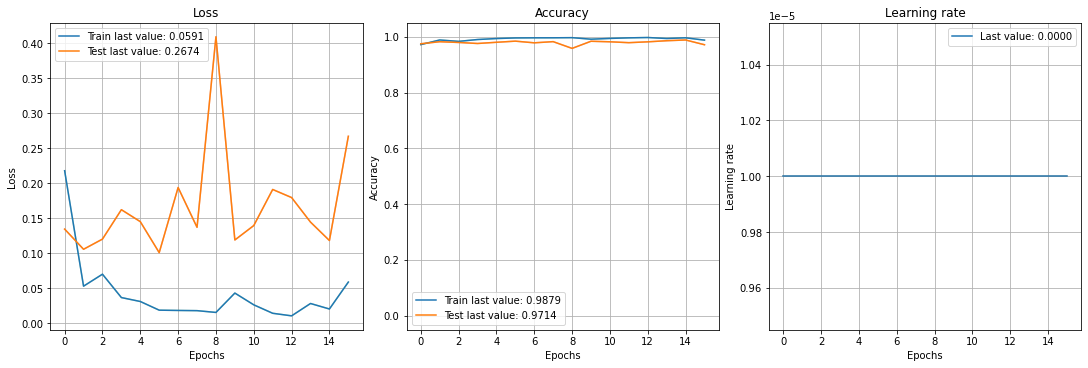

In [29]:
plot_history(history, path="finetuned_model_results_2.png")

In [80]:
# making predictions on test data
#test_steps_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)
predictions = model.predict(test_data)

In [81]:
predictions

array([[1.628134 ],
       [1.6457964],
       [1.4188577],
       ...,
       [2.8349116],
       [2.8819573],
       [2.814758 ]], dtype=float32)

In [39]:
# Converting predictions into model [0, 1]
pred_list = list(predictions)
predicted_classes = [1 if entry > 0.5 else 0 for entry in pred_list]

In [41]:
# Getting true classes,[0, 1] from test data
true_classes = test_data.classes
true_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

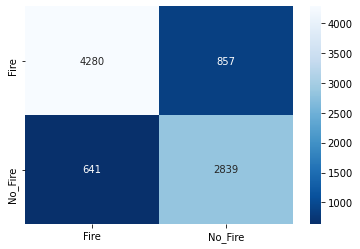

In [72]:
# Plotting Confusion Matrix
import seaborn as sns
cm=confusion_matrix(true_classes,predicted_classes)
plot_cm = sns.heatmap(cm,annot=True,
                      fmt='g',cmap='Blues_r',
                      xticklabels=['Fire', 'No_Fire'],
                      yticklabels=['Fire', 'No_Fire'])
#Fire is 0 and No_Fire is 1

plot_cm.figure.savefig("cfm.png")


In [75]:
print('Classification Report')
print(classification_report(test_data.classes, predicted_classes,target_names=['fire','no_fire']))

Classification Report
              precision    recall  f1-score   support

        fire       0.87      0.83      0.85      5137
     no_fire       0.77      0.82      0.79      3480

    accuracy                           0.83      8617
   macro avg       0.82      0.82      0.82      8617
weighted avg       0.83      0.83      0.83      8617



In [78]:
report = classification_report(test_data.classes,predicted_classes,target_names=['fire','no_fire'],output_dict=True)
df = pd.DataFrame(report).transpose()

In [79]:
df

,precision,recall,f1-score,support
fire,0.869742,0.833171,0.851064,5137.000000
no_fire,0.768128,0.815805,0.791249,3480.000000
accuracy,0.826158,0.826158,0.826158,0.826158
macro avg,0.818935,0.824488,0.821156,8617.000000
weighted avg,0.828705,0.826158,0.826907,8617.000000
